
<b>¡Hola Luz!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.  
¡Empecemos!


Resumen de analisis a desarrollar: Empresa de telecomunicacion CallMeMaybe requiere una herramienta funcional para los supervisores donde muestre cuales son los operadores ineficaces y asi poder tomar decisiones sobre mejorar sus procesos y cumplir con los requerimientos de los clientes. Realizando este analisis brindara informacion para la toma de decision en:

1. Disminuir el tiempo de espera
2. Que la totalidad de llamadas entrantes sean atendidas
3. Evidenciar el uso excesivo de comunicacion interna (llamadas internas)
4. Que los operadores sean más eficaces
5. Mejorar el nivel de satisfaccion del cliente final


In [3]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

# Describcion de datos
Callme= Callme = pd.read_csv("telecom_dataset_new.csv", sep=',')
Callme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy bien iniciar con <code>info()</code> tras la carga del CSV: te permitió ver tipos, nulos y tamaño del dataset antes de transformar. Esta práctica evita transformaciones a ciegas y facilita decidir dtypes y reglas de limpieza. Como micro-sugerencia, podrías leer ya tipificando y parseando fechas para ahorrar un paso: <code>pd.read_csv(..., parse_dates=['date'], dtype={'operator_id':'Int64'})</code>. Esto reduce conversiones posteriores y mantiene los NaN correctamente representados.
</div>

Existen columnas con tipo de dato incorrecto que se deben cambiar, asi mismo como valores ausentes en Internal (117) y Operador_id (8.172)

In [4]:
# Procesamiento de datos

# Convertir la columna 'date' a datetime
Callme['date'] = pd.to_datetime(Callme['date'], errors='coerce')


# Verificar el cambio
print(Callme['date'].dtypes)

datetime64[ns, pytz.FixedOffset(180)]


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Convertiste <code>date</code> a <code>datetime</code> con manejo de errores, ¡bien! Trabajar con fechas tipificadas abre la puerta a re-sampling y ventanas móviles. Si el offset horario es relevante para el negocio, conviene documentarlo; si no, podrías normalizar a UTC con <code>.dt.tz_convert('UTC')</code> o remover zona con <code>.dt.tz_localize(None)</code> para evitar mezclas inadvertidas al agrupar por día o semana.
</div>

In [5]:
# Eliminar filas donde 'internal' es NaN
Callme = Callme.dropna(subset=['internal'])
# Convertir la columna 'internal' a tipo boleano
Callme['internal'] = Callme['internal'].astype('bool')
# Convertir la columna 'operador_id' a tipo entero
Callme['operator_id'] = Callme['operator_id'].astype('Int64')
# Completar los valores ausentes con (0)
Callme['operator_id'] = pd.to_numeric(Callme['operator_id'], errors='coerce').fillna(0).astype(int)
Callme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  bool                                 
 4   operator_id          53785 non-null  int64                                
 5   is_missed_call       53785 non-null  bool                                 
 6   calls_count          53785 non-null  int64                                
 7   call_duration        53785 non-null  int64                                
 8   total_call_duration  53785 non-null  int64                                
dtypes: bool

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Hay dos puntos críticos en el preprocesamiento que afectan la validez de varios análisis posteriores:<br><br>
1) <b>Conversión de <code>internal</code> a bool</b>: usar <code>.astype('bool')</code> sobre texto transforma cualquier cadena no vacía en <i>True</i>, por lo que probablemente todas las filas quedaron como internas. Esto sesga comparativos internos vs externos y tasas de pérdidas. Mejor mapea explícitamente los valores: por ejemplo <code>Callme['internal'] = (Callme['internal'].astype(str).str.strip().str.lower().isin(['true','1','yes','y','si','sí']))</code>.<br><br>
2) <b>Relleno de <code>operator_id</code> con 0</b>: al convertir nulos a 0, ese 0 se comporta como un operador real en agrupaciones y outliers (se ve en varios resultados). Es preferible mantener <code>Int64</code> con NA, o crear una columna categórica para análisis: <code>Callme['operator_id_cat'] = Callme['operator_id'].astype('Int64').astype('string').fillna('Desconocido')</code>. Así no mezclas "desconocido" con IDs válidos y evitas conclusiones sesgadas.
</div>

## Analisis de Datos

In [6]:
# Resumen estadistico
Callme.describe().round(2)

# Promedio de llamadas por usuario y operador
promedio_por_usuario = Callme.groupby('user_id')['calls_count'].mean().round(2)
print(promedio_por_usuario)
promedio_por_operador = Callme.groupby('operator_id')['calls_count'].mean().round(2)
print(promedio_por_operador)

user_id
166377    10.06
166391     1.35
166392     2.27
166399     1.22
166405    18.44
          ...  
168583     1.69
168598     4.58
168601     9.66
168603     2.25
168606     2.58
Name: calls_count, Length: 307, dtype: float64
operator_id
0         13.99
879896     8.84
879898    31.89
880020     2.45
880022     2.88
          ...  
972410    19.25
972412    12.20
972460     7.78
973120     1.50
973286     2.00
Name: calls_count, Length: 1093, dtype: float64


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buen uso de <code>groupby</code> para obtener promedios por usuario y operador. Esto acerca el análisis al nivel de decisión del supervisor. Cuando explores cargas operativas, suele aportar calcular varias métricas juntas con <code>.agg({'calls_count':['mean','median','sum'],'is_missed_call':'mean'})</code>. Incluir mediana y suma ayuda a entender sesgos y volumen total en paralelo.
</div>

In [7]:
# Calculo de media y desviacion estandar de llamadas
media_llamadas = Callme['calls_count'].mean().round(2)
desv_llamadas = Callme['calls_count'].std().round(2)
print("Media:", media_llamadas)
print("Desviación estándar:", desv_llamadas)

Media: 16.48
Desviación estándar: 62.98


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Estimaste media y desviación estándar de <code>calls_count</code> para caracterizar la variabilidad. Dado que la desviación es muy alta respecto a la media, señalas una distribución sesgada con colas largas. En estos casos, conviene complementar con métricas robustas (mediana, IQR, percentiles 90/95) para decisiones menos sensibles a picos inusuales.
</div>

In [8]:
# Detección de volúmenes atípicos
umbral_superior = media_llamadas + 3 * desv_llamadas

# Filtrar llamadas atípicas
llamadas_atipicas = Callme[Callme['calls_count'] > umbral_superior]

print("Cantidad de registros atípicos:", len(llamadas_atipicas))
print(llamadas_atipicas.head())

Cantidad de registros atípicos: 454
      user_id                      date direction  internal  operator_id  \
1064   166405 2019-09-27 00:00:00+03:00        in     False            0   
1071   166405 2019-09-28 00:00:00+03:00        in     False            0   
1072   166405 2019-09-28 00:00:00+03:00        in     False            0   
1078   166405 2019-09-30 00:00:00+03:00        in     False            0   
1085   166405 2019-10-01 00:00:00+03:00        in     False            0   

      is_missed_call  calls_count  call_duration  total_call_duration  
1064            True          284              0                  818  
1071            True          263              0                  342  
1072            True          263              0                  342  
1078            True          598              0                  352  
1085            True          714              0                  467  


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La detección de atípicos vía regla de 3·σ es una primera pasada útil. Como mejora educativa, en variables con distribución no normal, puedes probar enfoque robusto: IQR (<code>q3 + 1.5*IQR</code>) o MAD. Esto reduce la influencia de valores extremos y te dará un conjunto de outliers más estable para seguimiento operativo.
</div>

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buena lectura de registros atípicos con <code>is_missed_call=True</code> y <code>call_duration=0</code>: es consistente con llamadas perdidas donde el tiempo total refleja la espera. Este tipo de chequeos de coherencia de negocio es clave para confiar en las métricas posteriores. Mantener un diccionario de reglas (p. ej., "si perdida → duración=0") te ayuda a automatizar validaciones.
</div>

In [9]:

# Calcular media y desviación estándar por operador
stats_operador = Callme.groupby('operator_id')['calls_count'].agg(['mean', 'std']).round(2)

print(stats_operador)
# Detectar valores atípicos por operador
# Unir estadísticas al dataframe original
Callme_stats = Callme.merge(
    stats_operador,
    on='operator_id',
    how='left'
)

# Calcular umbral por operador
Callme_stats['umbral_superior'] = Callme_stats['mean'] + 3 * Callme_stats['std']

# Filtrar registros atípicos
llamadas_atipicas_operador = Callme_stats[
    Callme_stats['calls_count'] > Callme_stats['umbral_superior']
]

print("Registros atípicos por operador:", len(llamadas_atipicas_operador))
print(llamadas_atipicas_operador.head())

              mean    std
operator_id              
0            13.99  81.48
879896        8.84  19.84
879898       31.89  32.87
880020        2.45   2.24
880022        2.88   2.38
...            ...    ...
972410       19.25   7.89
972412       12.20   7.85
972460        7.78   8.56
973120        1.50   0.71
973286        2.00    NaN

[1093 rows x 2 columns]
Registros atípicos por operador: 624
      user_id                      date direction  internal  operator_id  \
84     166377 2019-08-23 00:00:00+03:00       out     False       880026   
86     166377 2019-08-23 00:00:00+03:00       out     False       880026   
515    166377 2019-11-19 00:00:00+03:00       out     False       880022   
1013   166405 2019-09-19 00:00:00+03:00        in     False       882684   
1063   166405 2019-09-27 00:00:00+03:00        in     False            0   

      is_missed_call  calls_count  call_duration  total_call_duration   mean  \
84             False           43           3435               

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy valioso calcular outliers por operador con umbrales específicos. Así comparas a cada operador consigo mismo y no contra la media global. Pequeña mejora: maneja casos con <code>std</code> nula o NaN (operadores con muy pocos registros) imponiendo un mínimo de filas antes de marcar outliers, por ejemplo <code>groupby().filter(lambda g: len(g) >= 10)</code>. Evita falsos positivos en operadores de baja actividad.
</div>

1. Se detectaron 624 registros anómalos de llamadas por operador, lo que indica que existen picos de actividad fuera del comportamiento normal del grupo.

2. Los valores atipicos representan eventos de volumen de llamadas inusualmente altos, comparados con la distribución típica de cada operador.

3. Algunos operadores (como 880022 o 880026) tienen distribuciones estrechas, por lo que incluso un aumento moderado de llamadas puede indicar comportamiento irregular.

In [10]:
# Calcular tiempo de espera
tiempo_espera = Callme['total_call_duration'] - Callme['call_duration']
# Crear la columna de tiempo de espera
Callme['tiempo_espera'] = Callme['total_call_duration'] - Callme['call_duration']
# Separar llamadas con y sin espera
sin_espera = Callme[Callme['tiempo_espera'] == 0]

# Llamadas con espera (tiempo_espera > 0)
con_espera = Callme[Callme['tiempo_espera'] > 0]

# Calcular diferencias y métricas clave
promedio_sin_espera = sin_espera['tiempo_espera'].mean().round(2)
promedio_con_espera = con_espera['tiempo_espera'].mean().round(2)

# Diferencia
diferencia = promedio_con_espera - promedio_sin_espera

print("Promedio espera sin demora:", promedio_sin_espera)
print("Promedio espera con demora:", promedio_con_espera)
print("Diferencia de eficiencia:", diferencia)

Promedio espera sin demora: 0.0
Promedio espera con demora: 298.54
Diferencia de eficiencia: 298.54


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Definiste correctamente el <i>tiempo de espera</i> como <code>total_call_duration - call_duration</code>. Es útil aclarar que en llamadas perdidas <code>call_duration</code> suele ser 0, por lo que el valor refleja toda la espera. Para priorizar acciones, conviene revisar percentiles (p50, p80, p95) y la proporción de llamadas con espera > 60, 120 y 180 segundos; esto guía metas realistas de reducción.
</div>

Con el resultado evidenciado un tiempo de espera promedio de 298.54 segundos (≈ 5 minutos) es muy elevado para estándares de atención telefónica. Aceptable es un minuto, lo que se concluye es que hay un problema operativo, un impacto directo en la experiencia del usuario y esto afecta significativamente la eficiencia y la calidad del servicio.

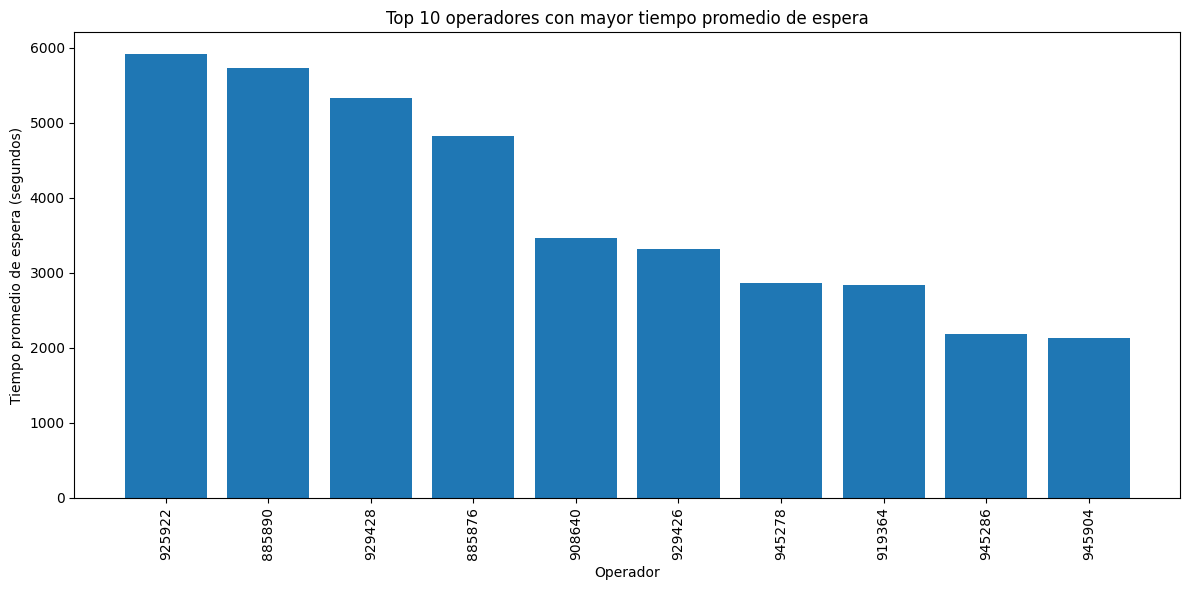

In [11]:
# Calcular el promedio de espera por operador y seleccionar el TOP 10
top10 = (
    Callme.groupby('operator_id')['tiempo_espera']
          .mean()
          .sort_values(ascending=False)
          .head(10)
)

# Crear gráfico
plt.figure(figsize=(12,6))
plt.bar(top10.index.astype(str), top10.values)
plt.xticks(rotation=90)
plt.xlabel("Operador")
plt.ylabel("Tiempo promedio de espera (segundos)")
plt.title("Top 10 operadores con mayor tiempo promedio de espera")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buen TOP 10 de operadores por espera promedio. Dos micro-sugerencias visuales que ayudan al supervisor: usar barras horizontales (<code>barh</code>) para leer etiquetas largas y formatear a minutos con una etiqueta secundaria (ej. "5.2 min"). Además, si mantienes "Desconocido"/NA separado de IDs válidos, el ranking reflejará mejor oportunidades reales.
</div>

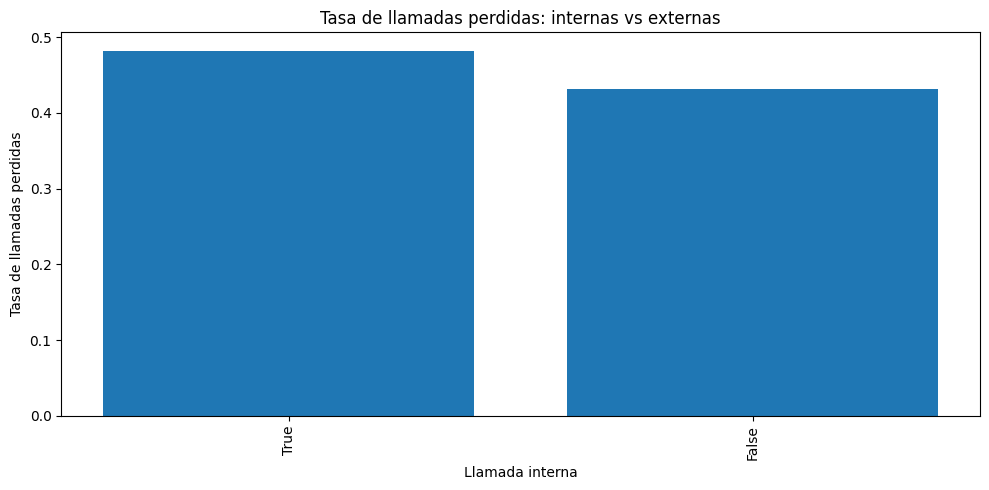

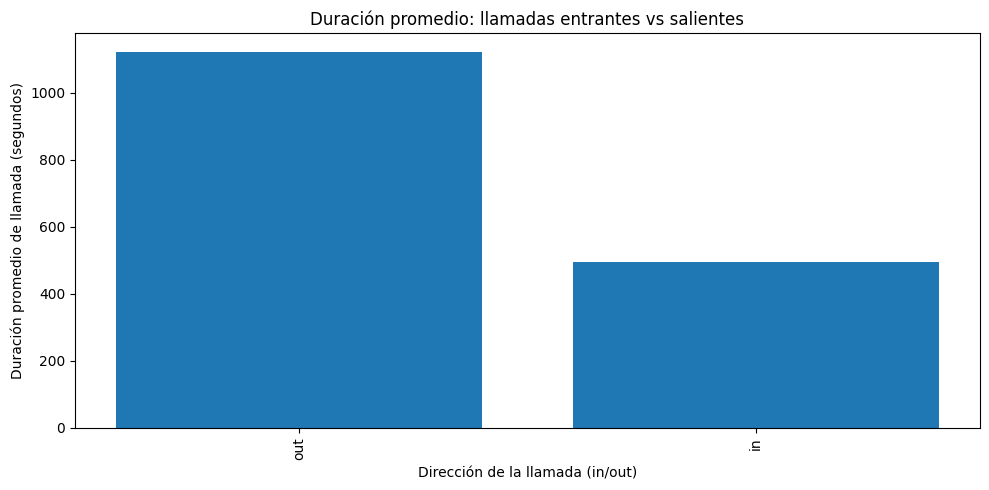

In [12]:
# Comparativo duracion de llamadas internas y externas
tasa_internal = (
    Callme.groupby('internal')['is_missed_call']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
plt.bar(tasa_internal.index.astype(str), tasa_internal.values)
plt.xlabel("Llamada interna")
plt.ylabel("Tasa de llamadas perdidas")
plt.title("Tasa de llamadas perdidas: internas vs externas")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ------------------------------
# DURACIÓN PROMEDIO: ENTRANTES (in) VS SALIENTES (out)
# ------------------------------
duracion_in_out = (
    Callme.groupby('direction')['call_duration']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
plt.bar(duracion_in_out.index.astype(str), duracion_in_out.values)
plt.xlabel("Dirección de la llamada (in/out)")
plt.ylabel("Duración promedio de llamada (segundos)")
plt.title("Duración promedio: llamadas entrantes vs salientes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
El comparativo de llamadas internas vs externas depende de la columna <code>internal</code> y, por la conversión a <code>bool</code>, es probable que todas las filas aparezcan como internas. Esto invalida la comparación y cualquier conclusión asociada. Tras corregir el mapeo de <code>internal</code> (ver sugerencia en la celda de limpieza), vuelve a calcular la tasa de pérdidas y analiza si las internas consumen tiempo que impacta la atención externa. Así podrás orientar reglas de uso de la comunicación interna.
</div>

In [13]:
# correlación entre la duración de llamada y la probabilidad de pérdida.
correlacion = Callme['call_duration'].corr(Callme['is_missed_call'])
print("Correlación entre duración de llamada y llamadas perdidas:", correlacion)

Correlación entre duración de llamada y llamadas perdidas: -0.2046058996219289


In [14]:
# Calcular correlación entre tiempo de espera y pérdida
Callme['tiempo_espera'] = Callme['total_call_duration'] - Callme['call_duration']

correlacion_espera = Callme['tiempo_espera'].corr(Callme['is_missed_call'])
print("Correlación entre tiempo de espera y llamadas perdidas:", correlacion_espera)

Correlación entre tiempo de espera y llamadas perdidas: 0.048692507584979575


In [15]:
# Matriz de correlación completa 
corr_matrix = Callme[['call_duration', 'total_call_duration', 'tiempo_espera', 'is_missed_call']].corr().round(2)
print(corr_matrix)

                     call_duration  total_call_duration  tiempo_espera  \
call_duration                 1.00                 0.98           0.50   
total_call_duration           0.98                 1.00           0.68   
tiempo_espera                 0.50                 0.68           1.00   
is_missed_call               -0.20                -0.16           0.05   

                     is_missed_call  
call_duration                 -0.20  
total_call_duration           -0.16  
tiempo_espera                  0.05  
is_missed_call                 1.00  


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Excelente incorporar correlaciones. Leer <code>is_missed_call</code> como 0/1 te da una correlación de tipo biserial, útil para medir dirección y fuerza. La relación débil entre espera y pérdida sugiere que no basta con mirar promedios globales; segmentar por hora, día de la semana o tipo de llamada suele revelar patrones más claros para ajustar staffing y reglas de ruteo.
</div>

Correlación negativa → las llamadas cortas se pierden más
Correlación positiva → las llamadas largas se pierden más
Correlación cercana a cero → no hay relación real
Con tiempo_espera, normalmente encontrarás correlación positiva (más espera = más pérdida)

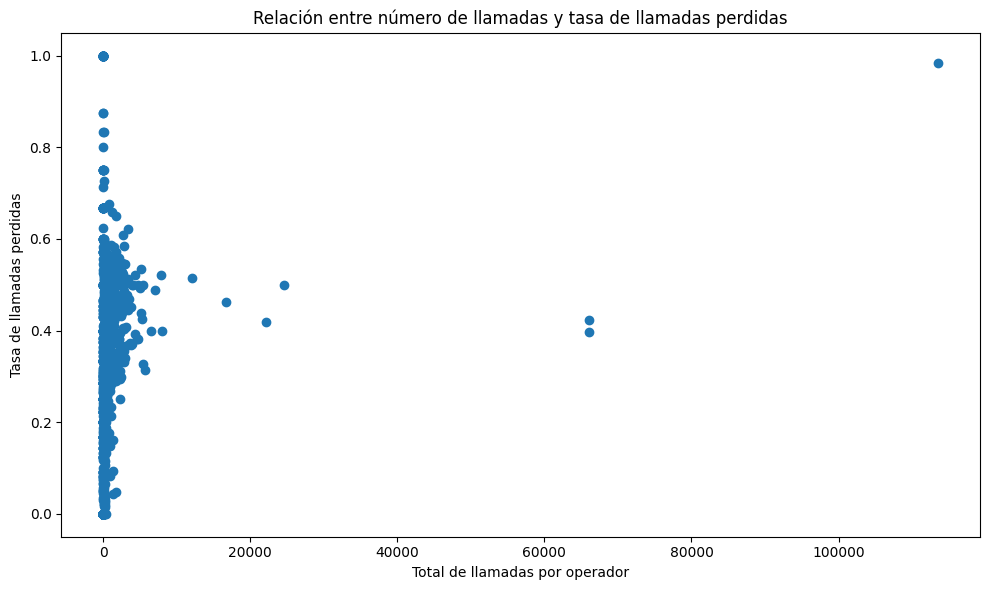

In [16]:
# Tasa de llamadas perdidas vs cantidad de llamadas por operador
# Agrupar por operador
stats_operador = Callme.groupby('operator_id').agg({
    'calls_count': 'sum',
    'call_duration': 'sum',
    'is_missed_call': 'mean'
}).reset_index()

# Renombrar para claridad
stats_operador = stats_operador.rename(columns={
    'calls_count': 'total_llamadas',
    'call_duration': 'total_duracion',
    'is_missed_call': 'tasa_perdidas'
})

# --- Gráfico 1: más llamadas vs tasa de pérdidas ---
plt.figure(figsize=(10,6))
plt.scatter(stats_operador['total_llamadas'], stats_operador['tasa_perdidas'])
plt.xlabel("Total de llamadas por operador")
plt.ylabel("Tasa de llamadas perdidas")
plt.title("Relación entre número de llamadas y tasa de llamadas perdidas")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Muy buena idea cruzar volumen/duración total por operador con la tasa de pérdidas. Para mejorar la legibilidad en datos sesgados, conviene usar <code>alpha</code> bajo y ejes logarítmicos, y resaltar con etiquetas los casos extremos (mejores y peores). Esto permite identificar rápidamente operadores que requieren coaching o que merecen reconocimiento.
</div>

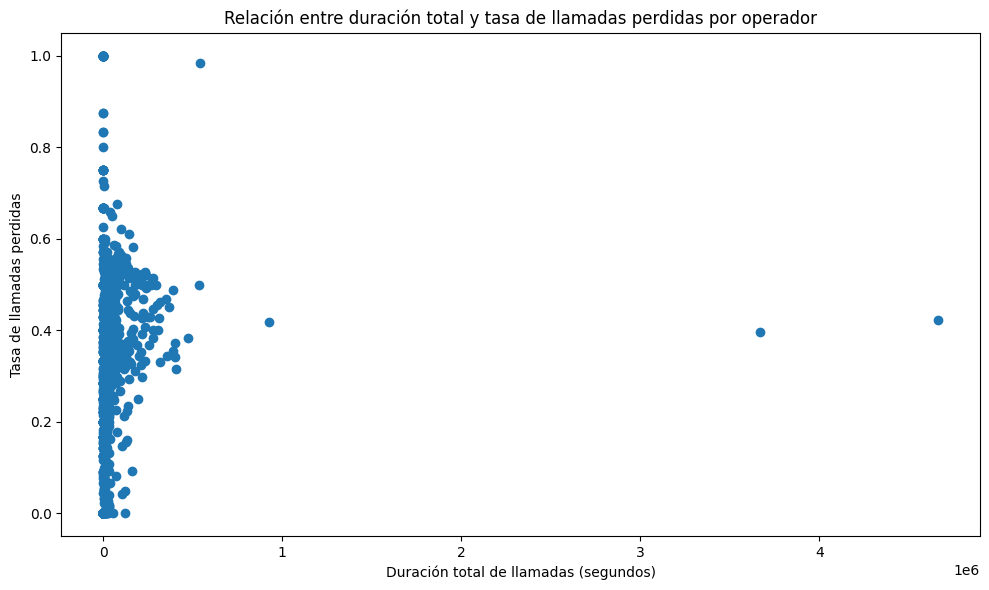

In [17]:
# Tasa de llamadas perdidas vs duración total por operador
plt.figure(figsize=(10,6))
plt.scatter(stats_operador['total_duracion'], stats_operador['tasa_perdidas'])
plt.xlabel("Duración total de llamadas (segundos)")
plt.ylabel("Tasa de llamadas perdidas")
plt.title("Relación entre duración total y tasa de llamadas perdidas por operador")
plt.tight_layout()
plt.show()


In [18]:
# Definir umbrales para categorización
umbral_alto_volumen = stats_operador['total_llamadas'].quantile(0.75)  # Top 25%
umbral_baja_perdida = stats_operador['tasa_perdidas'].quantile(0.25)   # Bottom 25%
umbral_alta_perdida = stats_operador['tasa_perdidas'].quantile(0.75)   # Top 25%

print(f"Umbral alto volumen: {umbral_alto_volumen:.0f} llamadas")
print(f"Umbral baja pérdida: {umbral_baja_perdida:.2f}")
print(f"Umbral alta pérdida: {umbral_alta_perdida:.2f}")

Umbral alto volumen: 558 llamadas
Umbral baja pérdida: 0.12
Umbral alta pérdida: 0.46


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Definiste umbrales con cuantiles, un enfoque práctico y estable. Al categorizar en la siguiente celda, procura mantener consistencia: o bien todo por cuantiles, o bien reglas fijas de negocio, y añade un mínimo de llamadas por operador (p. ej., ≥ 30) para evitar clasificar como "problemático" a quien solo tuvo 1–2 interacciones, donde la tasa es muy volátil.
</div>

In [19]:
# Crear función de categorización
def categorizar_operador(row):
    volumen = row['total_llamadas']
    perdida = row['tasa_perdidas']
    
    if volumen >= umbral_alto_volumen and perdida <= umbral_baja_perdida:
        return "⭐ ESTRELLA"
    elif volumen >= umbral_alto_volumen and perdida <= 0.5:
        return "🔥 ALTO_RENDIMIENTO"
    elif volumen < 1000 and perdida >= umbral_alta_perdida:
        return "❌ PROBLEMÁTICO"
    elif volumen < 1000:
        return "😴 INACTIVO"
    elif perdida >= umbral_alta_perdida:
        return "⚠️ NECESITA_MEJORA"
    else:
        return "✅ PROMEDIO"

# Aplicar categorización
stats_operador['categoria'] = stats_operador.apply(categorizar_operador, axis=1)

# Contar operadores por categoría
resumen_categorias = stats_operador['categoria'].value_counts()
print("\n📊 RESUMEN POR CATEGORÍAS:")
print(resumen_categorias)

# Operadores ESTRELLA (Alto volumen + Baja pérdida)
operadores_estrella = stats_operador[stats_operador['categoria'] == "⭐ ESTRELLA"]
print("\n🌟 OPERADORES ESTRELLA:")
print(operadores_estrella[['operator_id', 'total_llamadas', 'tasa_perdidas']].sort_values('tasa_perdidas'))

# Operadores PROBLEMÁTICOS
operadores_problema = stats_operador[stats_operador['categoria'] == "❌ PROBLEMÁTICO"]
print("\n❌ OPERADORES PROBLEMÁTICOS:")
print(operadores_problema[['operator_id', 'total_llamadas', 'tasa_perdidas']].sort_values('tasa_perdidas', ascending=False))


📊 RESUMEN POR CATEGORÍAS:
😴 INACTIVO            655
🔥 ALTO_RENDIMIENTO    213
❌ PROBLEMÁTICO        173
⚠️ NECESITA_MEJORA     48
⭐ ESTRELLA              4
Name: categoria, dtype: int64

🌟 OPERADORES ESTRELLA:
     operator_id  total_llamadas  tasa_perdidas
469       919794            1348       0.042553
467       919790            1815       0.048193
468       919792             913       0.081818
465       919552            1307       0.092437

❌ OPERADORES PROBLEMÁTICOS:
      operator_id  total_llamadas  tasa_perdidas
161        899076               2       1.000000
254        905480               1       1.000000
1068       969284               1       1.000000
1012       958458               1       1.000000
618        932246               1       1.000000
...           ...             ...            ...
834        944648              52       0.464286
373        914050             438       0.462963
41         888406              15       0.461538
616        932050             

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La categorización de operadores aporta mucha acción para supervisión: estrella, alto rendimiento, problemático, etc. Para hacerla aún más justa, podrías: (1) exigir mínimo de llamadas por categoría, (2) usar límites consistentes (solo cuantiles o solo reglas fijas), y (3) aplicar intervalos de confianza de Wilson a la tasa de pérdidas, de modo que el ranking no castigue muestras pequeñas.
</div>

Con el resultado obtenido podemos indiar que solo 4 Operadores cumplen con el servicio al cliente y que 173 hay que analizar y estan categorizados problematicos y 48 por mejorar.

In [20]:
# Agrupar por fecha
Callme['solo_fecha'] = Callme['date'].dt.date
Callme.groupby('solo_fecha').agg({
    'calls_count': 'sum',
    'call_duration': 'sum',
    'total_call_duration': 'sum'
})

,calls_count,call_duration,total_call_duration
solo_fecha,,,
2019-08-02,21,163,493
2019-08-03,30,962,1454
2019-08-04,6,114,153
2019-08-05,200,7548,9650
2019-08-06,264,15516,18093
...,...,...,...
2019-11-24,4674,260781,347715
2019-11-25,19290,964606,1299757
2019-11-26,17648,908759,1222392


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Agrupar por fecha con una columna <code>solo_fecha</code> es una forma limpia de preparar series diarias sin complicaciones de zona horaria. Si necesitas comparar semanas, considera agregar <code>weekofyear</code> y <code>dayofweek</code> para ver si los picos se repiten, lo que te guía en la planificación de turnos.
</div>

In [21]:
# Agrupar datos por día para obtener métricas diarias
metricas_diarias = Callme.groupby('solo_fecha').agg({
    'calls_count': 'sum',           # Total de llamadas
    'call_duration': 'mean',        # Promedio de duración
    'is_missed_call': 'mean',       # Tasa de llamadas perdidas
    'total_call_duration': 'sum'    # Para cálculos adicionales
}).round(2)

# Renombrar columnas para mayor claridad
metricas_diarias = metricas_diarias.rename(columns={
    'calls_count': 'total_llamadas',
    'call_duration': 'promedio_duracion',
    'is_missed_call': 'tasa_perdidas',
    'total_call_duration': 'duracion_total'
})

# Mostrar las primeras filas
print("📊 MÉTRICAS DIARIAS:")
print(metricas_diarias.head(10))


📊 MÉTRICAS DIARIAS:
            total_llamadas  promedio_duracion  tasa_perdidas  duracion_total
solo_fecha                                                                  
2019-08-02              21              20.38           0.62             493
2019-08-03              30             106.89           0.56            1454
2019-08-04               6              28.50           0.75             153
2019-08-05             200             444.00           0.59            9650
2019-08-06             264             705.27           0.59           18093
2019-08-07             198             514.65           0.55           12500
2019-08-08             378             543.45           0.45           20727
2019-08-09             413             388.13           0.58           20660
2019-08-10              12              26.43           0.71             475
2019-08-11               2               0.00           1.00              22


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Las métricas diarias están muy bien pensadas: total, promedio de duración y tasa de pérdidas. Con esto ya puedes construir alertas. Como siguiente paso, un desglose por día de la semana y franja horaria (heatmap) ayuda a alinear turnos y descansos con la demanda real, reduciendo esperas en picos sin sobrecargar en valles.
</div>

In [22]:
# Detectar picos de demanda y caídas de rendimiento

# Calcular estadísticas para identificar picos y caídas
media_llamadas = metricas_diarias['total_llamadas'].mean()
std_llamadas = metricas_diarias['total_llamadas'].std()

print(f"📈 ANÁLISIS DE PATRONES:")
print(f"Promedio de llamadas diarias: {media_llamadas:.1f}")
print(f"Desviación estándar: {std_llamadas:.1f}")
print()

# Definir umbrales para picos y caídas
umbral_pico = media_llamadas + std_llamadas
umbral_caida = media_llamadas - std_llamadas

print(f"🔥 PICOS DE DEMANDA (>{umbral_pico:.0f} llamadas):")
picos = metricas_diarias[metricas_diarias['total_llamadas'] > umbral_pico]
print(picos[['total_llamadas', 'promedio_duracion', 'tasa_perdidas']])
print()

print(f"📉 CAÍDAS DE RENDIMIENTO (<{umbral_caida:.0f} llamadas):")
caidas = metricas_diarias[metricas_diarias['total_llamadas'] < umbral_caida]
print(caidas[['total_llamadas', 'promedio_duracion', 'tasa_perdidas']])

📈 ANÁLISIS DE PATRONES:
Promedio de llamadas diarias: 7449.8
Desviación estándar: 5781.3

🔥 PICOS DE DEMANDA (>13231 llamadas):
            total_llamadas  promedio_duracion  tasa_perdidas
solo_fecha                                                  
2019-10-01           15813            1159.93           0.45
2019-10-02           13503            1153.34           0.44
2019-10-03           14403            1214.71           0.46
2019-10-04           13929            1121.89           0.44
2019-10-07           15324            1137.25           0.45
2019-10-08           16573            1115.53           0.45
2019-10-09           15072            1124.39           0.45
2019-10-10           16229            1184.77           0.43
2019-10-11           19160            1108.01           0.44
2019-10-14           13897             960.50           0.44
2019-10-15           14776             865.81           0.45
2019-10-31           13472             651.90           0.43
2019-11-05        

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Detectaste picos/caídas con media ± σ y listaste fechas. Es un buen radar. Para operacionalizarlo, suma un promedio móvil de 7 días y banderas por estacionalidad (día hábil vs fin de semana). Así evitas falsas alarmas por patrones regulares y enfocás atención en anomalías verdaderas o eventos especiales.
</div>

/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128222 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/.venv/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128293 missing from current font.
  font.set_text(s, 0, flags=fla

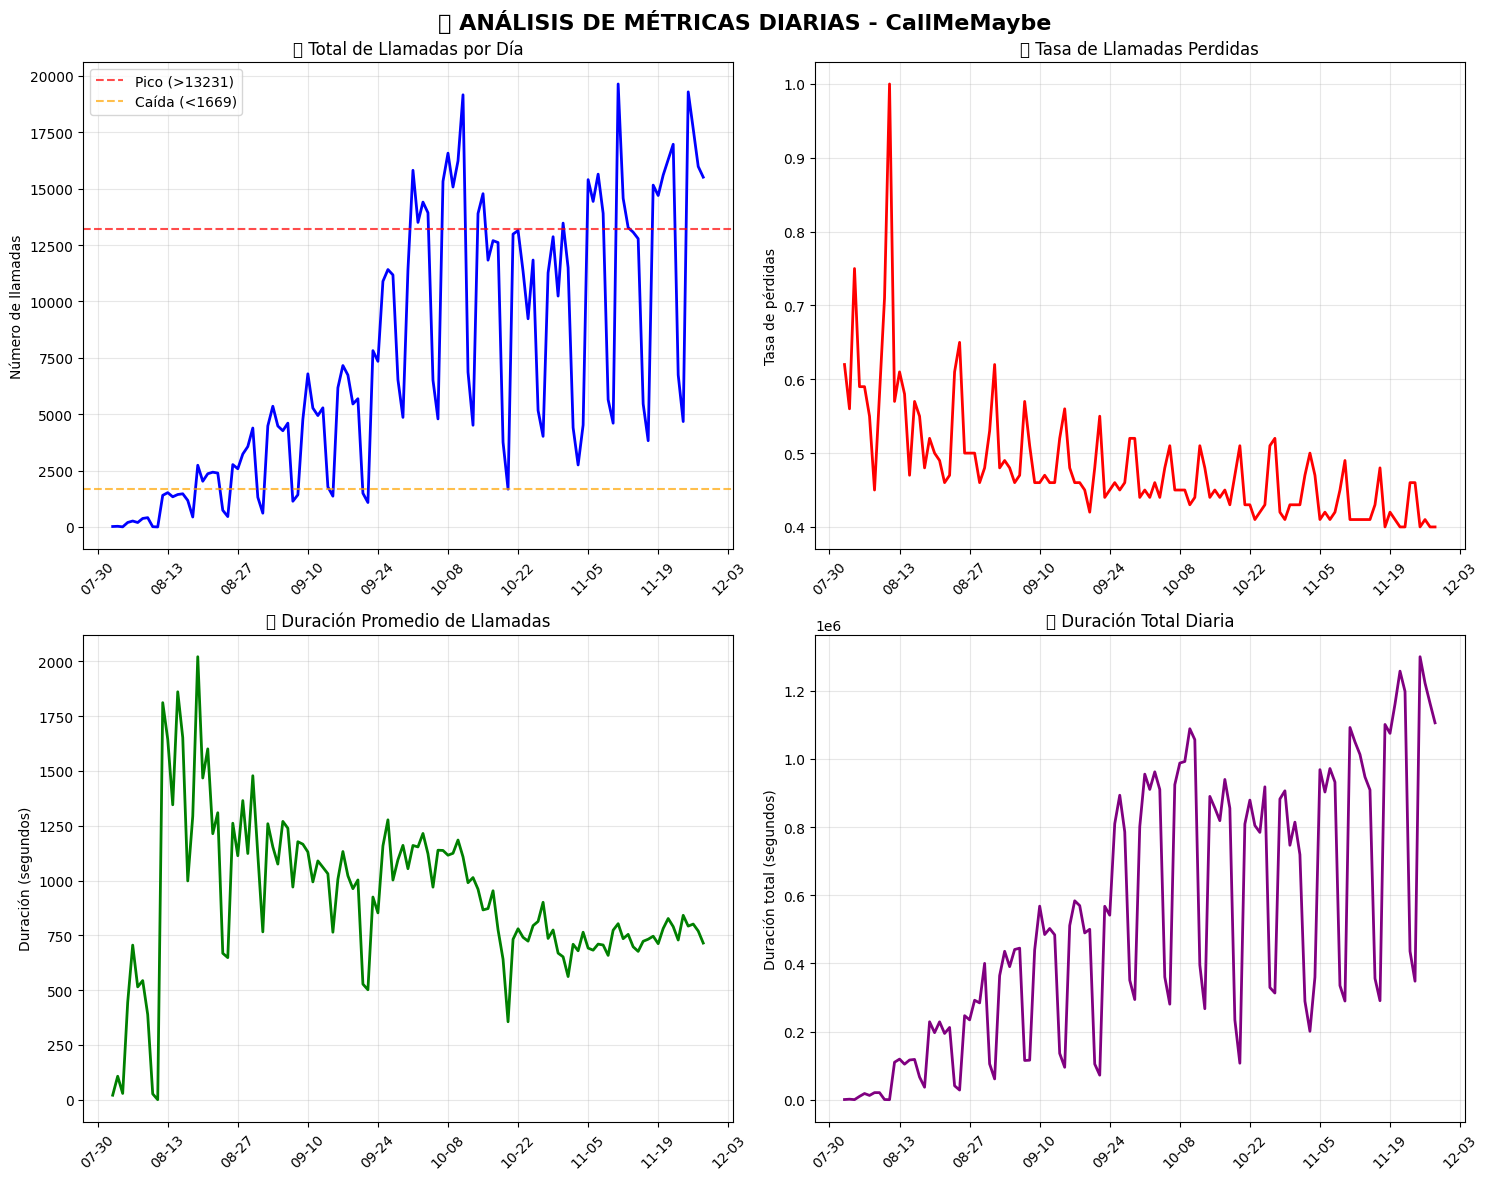

In [23]:
# Crear visualizaciones de métricas diarias

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


# Convertir el índice a datetime para mejor visualización
metricas_diarias.index = pd.to_datetime(metricas_diarias.index)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 ANÁLISIS DE MÉTRICAS DIARIAS - CallMeMaybe', fontsize=16, fontweight='bold')

# Gráfico 1: Total de llamadas diarias
axes[0,0].plot(metricas_diarias.index, metricas_diarias['total_llamadas'], 
               color='blue', linewidth=2)
axes[0,0].axhline(y=umbral_pico, color='red', linestyle='--', alpha=0.7, label=f'Pico (>{umbral_pico:.0f})')
axes[0,0].axhline(y=umbral_caida, color='orange', linestyle='--', alpha=0.7, label=f'Caída (<{umbral_caida:.0f})')
axes[0,0].set_title('🔥 Total de Llamadas por Día')
axes[0,0].set_ylabel('Número de llamadas')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Tasa de llamadas perdidas
axes[0,1].plot(metricas_diarias.index, metricas_diarias['tasa_perdidas'], 
               color='red', linewidth=2)
axes[0,1].set_title('📞 Tasa de Llamadas Perdidas')
axes[0,1].set_ylabel('Tasa de pérdidas')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Promedio de duración
axes[1,0].plot(metricas_diarias.index, metricas_diarias['promedio_duracion'], 
               color='green', linewidth=2)
axes[1,0].set_title('⏱️ Duración Promedio de Llamadas')
axes[1,0].set_ylabel('Duración (segundos)')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Duración total diaria
axes[1,1].plot(metricas_diarias.index, metricas_diarias['duracion_total'], 
               color='purple', linewidth=2)
axes[1,1].set_title('📈 Duración Total Diaria')
axes[1,1].set_ylabel('Duración total (segundos)')
axes[1,1].grid(True, alpha=0.3)

# Formatear fechas en el eje x
for ax in axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
El panel de 4 subgráficos está claro y ordenado. Notaste los avisos de fuente por emojis; para evitarlo, puedes reemplazar emojis por texto simple o indicar una fuente que los soporte (<code>plt.rcParams['font.sans-serif']=['DejaVu Sans']</code>). Añadir líneas verticales en inicios de mes y anotar eventos relevantes facilita una lectura ejecutiva muy rápida.
</div>

Se evidencia que hubo picos de demanda en Octubre y Noviembre de 2019 de 19.160 y 19640 respectivamente estos picos son en dias laborales especificos.

Asi mismo hubo caidas de rendimiento en Agosto 2019 se puede indicar que corresponde al inicio del sistema.

Con esta informacion se puede recomendar en mejorar el rendimiento en los dias de baja actividad y optimizar la distribuciones de operadores en los periodos criticos

In [27]:
# CÁLCULO DE KPIs ESPECÍFICOS
# ========================================

# 1. NIVEL DE SERVICIO (SL)
# Definir umbral de tiempo aceptable (60 segundos)
umbral_tiempo = 60

# Total de llamadas entrantes
total_llamadas_entrantes = len(Callme)

# Llamadas respondidas dentro del umbral de tiempo
llamadas_dentro_umbral = len(Callme[
    (Callme['is_missed_call'] == False) & 
    (Callme['tiempo_espera'] <= umbral_tiempo)
])

# Calcular Nivel de Servicio
nivel_servicio = (llamadas_dentro_umbral / total_llamadas_entrantes) * 100

# 2. TASA DE LLAMADAS PERDIDAS (TP)
llamadas_perdidas = Callme['is_missed_call'].sum()
tasa_llamadas_perdidas = (llamadas_perdidas / total_llamadas_entrantes) * 100

# 3. TIEMPO MEDIO DE MANEJO (AHT)
# AHT = (Tiempo de conversación + Tiempo de espera) / número total de llamadas
tiempo_medio_manejo = (Callme['call_duration'].sum() + Callme['tiempo_espera'].sum()) / total_llamadas_entrantes

# ========================================
# FUNCIÓN PARA CREAR KPI CARDS
# ========================================
def crear_kpi_card(valor, titulo, formato="", color="blue", descripcion=""):
    card_html = f'''
    <div style="background: linear-gradient(135deg, {color}, #f8f9fa); 
                padding: 20px; margin: 10px; border-radius: 10px; 
                text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h2 style="color: white; margin: 0; font-size: 2.5em;">{valor:.1f}{formato}</h2>
        <p style="color: white; margin: 5px 0; font-size: 1.2em; font-weight: bold;">{titulo}</p>
        <p style="color: white; margin: 0; font-size: 0.9em; opacity: 0.9;">{descripcion}</p>
    </div>
    '''
    return card_html
    # ========================================
# MOSTRAR RESULTADOS DE KPIs
# ========================================
print("📊 INDICADORES CLAVE DE RENDIMIENTO (KPIs)")
print("=" * 50)
print(f"🎯 NIVEL DE SERVICIO: {nivel_servicio:.1f}%")
print(f"   (Llamadas respondidas en ≤60 seg: {llamadas_dentro_umbral:,} de {total_llamadas_entrantes:,})")
print()
print(f"📞 TASA DE LLAMADAS PERDIDAS: {tasa_llamadas_perdidas:.1f}%")
print(f"   (Llamadas perdidas: {llamadas_perdidas:,} de {total_llamadas_entrantes:,})")
print()
print(f"⏱️ TIEMPO MEDIO DE MANEJO: {tiempo_medio_manejo:.1f} segundos")
print(f"   ({tiempo_medio_manejo/60:.1f} minutos)")
print("=" * 50)


📊 INDICADORES CLAVE DE RENDIMIENTO (KPIs)
🎯 NIVEL DE SERVICIO: 29.7%
   (Llamadas respondidas en ≤60 seg: 15,977 de 53,785)

📞 TASA DE LLAMADAS PERDIDAS: 43.7%
   (Llamadas perdidas: 23,510 de 53,785)

⏱️ TIEMPO MEDIO DE MANEJO: 1159.5 segundos
   (19.3 minutos)


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Los KPIs están bien planteados, pero la implementación necesita ajustes para reflejar estándares de call center:<br><br>
• <b>Nivel de servicio (SL)</b>: se calcula sobre llamadas <i>entrantes ofrecidas</i> y el numerador son las <i>respondidas dentro del umbral</i>. Filtra por <code>direction=='in'</code> y no incluyas salientes/internas en el denominador.<br>
• <b>Tasa de pérdidas</b>: sobre entrantes ofrecidas, no sobre todo el dataset.<br>
• <b>AHT</b>: se suele medir en <i>llamadas atendidas</i> (no incluye perdidas).<br><br>
Sugerencia de corrección mínima:<br>
<code>inbound = Callme[Callme['direction']=='in']\nrespuestas = inbound[~inbound['is_missed_call']]\nofrecidas = len(inbound)\ndentro_60 = len(respuestas[respuestas['tiempo_espera'] <= 60])\nnivel_servicio = 100 * dentro_60 / ofrecidas\ntasa_perdidas = 100 * inbound['is_missed_call'].mean()\naht = (respuestas['call_duration'].sum() + respuestas['tiempo_espera'].sum()) / len(respuestas)</code><br><br>
Con estos ajustes, las conclusiones ejecutivas se alinean mejor con prácticas de la industria y evitan subestimar el desempeño real de los operadores.
</div>

De acuerdo con los resultado de los KPIs especificos se debe trabajar de manera inmediata en la experiencia del usuario, disminuir considerablemente la tasa de llamadas perdidas y que el tiempo de atencion sea menor ya que el tiempo es crucial para las partes interesadas. 

# Resumen Ejecutivo PDF
https://drive.google.com/file/d/1MBd2rUl-ow7JmD9X5WQ_OCiBWM_vrHz_/view?usp=drive_link

In [ ]:
# Link Tableu Dashboard
https://public.tableau.com/app/profile/luz.angela.rodriguez.alvarado/viz/DashboardProyectoFinalCallmeMaybe/Dashboard1?publish=yes

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Luz! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Estructuraste el flujo: carga, limpieza, análisis descriptivo y KPIs de forma ordenada.<br>
• Tipificaste fechas y usaste agrupaciones por operador/usuario con sentido de negocio.<br>
• Detectaste outliers globales y por operador, acercando el análisis a la acción.<br>
• Definiste correctamente el tiempo de espera y lo conectaste con impacto en servicio.<br>
• Construiste métricas diarias que permiten monitoreo y detección de picos/caídas.<br>
• Incorporaste correlaciones para entender relaciones entre duración y pérdidas.<br>
• Visualizaste comparativos clave que facilitan lectura ejecutiva.<br>
• Usaste cuantiles para fijar umbrales y categorizar operadores en niveles útiles.<br>
• Trasladaste hallazgos a recomendaciones concretas para supervisión.<br>
• Mantuvista un enfoque claro en reducir espera, pérdidas y mejorar eficiencia.<br>
<br>
¡Felicidades!
</div>